## 1. Project Setup

**Load Data & Packages**

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import os
import analyze_k
SEED = 12

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

import load_data as ld
df, train_indices, valid_indices= ld.load_train_data()
from evaluate_classification import evaluate_classification
from sklearn.model_selection import train_test_split
from evaluate_classification import evaluate_classification
import loops

df, train_indices, valid_indices = ld.load_train_data(filepath = 'Kaggle_download/train.csv')
scaler = MinMaxScaler()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# below lines unnecessary?
X_train = df.drop(columns="Target")
y_train = df.loc[:, 'Target']

### Out of the Box

#### Naive Bayes

In [3]:
nb = ComplementNB()
nb_results = loops.loop_model(nb, df, train_indices, valid_indices, inc_cm=False)

Accuracy: 0.49
Weighted F1 Score: 0.48
Macro F1 Score: 0.24
Precision: Class 1: 1.0 Class 2: 0.19  Class 3: 1.0
           Class 4: 0.73
Recall: Class 1: 0.0 Class 2: 0.56  Class 3: 0.0
        Class 4: 0.62


Accuracy: 0.53
Weighted F1 Score: 0.51
Macro F1 Score: 0.25
Precision: Class 1: 1.0 Class 2: 0.21  Class 3: 1.0
           Class 4: 0.73
Recall: Class 1: 0.0 Class 2: 0.56  Class 3: 0.0
        Class 4: 0.68


Accuracy: 0.52
Weighted F1 Score: 0.5
Macro F1 Score: 0.26
Precision: Class 1: 1.0 Class 2: 0.22  Class 3: 1.0
           Class 4: 0.75
Recall: Class 1: 0.0 Class 2: 0.65  Class 3: 0.0
        Class 4: 0.64


Accuracy: 0.51
Weighted F1 Score: 0.5
Macro F1 Score: 0.25
Precision: Class 1: 1.0 Class 2: 0.19  Class 3: 1.0
           Class 4: 0.74
Recall: Class 1: 0.0 Class 2: 0.56  Class 3: 0.0
        Class 4: 0.65


Accuracy: 0.5
Weighted F1 Score: 0.49
Macro F1 Score: 0.24
Precision: Class 1: 1.0 Class 2: 0.2  Class 3: 1.0
           Class 4: 0.73
Recall: Class 1: 0.0 Class 

In [4]:
avg_nb = analyze_k.average_outcome(nb_results)
avg_nb

{'accuracy': 0.5099199275669863,
 'f1': 0.4966067069661597,
 'Macro f1': 0.24699386946327015,
 'recall_1': 0.0,
 'precision_1': 1.0,
 'recall_2': 0.5792390194075587,
 'precision_2': 0.20278332354668233,
 'recall_3': 0.0,
 'precision_3': 1.0,
 'recall_4': 0.6448252344416028,
 'precision_4': 0.7369148205118234}

### KNN 

In [5]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_results = loops.loop_model(knn, df, train_indices, valid_indices, inc_cm=False)

Accuracy: 0.61
Weighted F1 Score: 0.56
Macro F1 Score: 0.3
Precision: Class 1: 0.18 Class 2: 0.26  Class 3: 0.17
           Class 4: 0.69
Recall: Class 1: 0.07 Class 2: 0.17  Class 3: 0.08
        Class 4: 0.86


Accuracy: 0.63
Weighted F1 Score: 0.56
Macro F1 Score: 0.29
Precision: Class 1: 0.14 Class 2: 0.34  Class 3: 0.14
           Class 4: 0.69
Recall: Class 1: 0.04 Class 2: 0.17  Class 3: 0.06
        Class 4: 0.9


Accuracy: 0.61
Weighted F1 Score: 0.54
Macro F1 Score: 0.26
Precision: Class 1: 0.06 Class 2: 0.24  Class 3: 0.11
           Class 4: 0.69
Recall: Class 1: 0.02 Class 2: 0.11  Class 3: 0.04
        Class 4: 0.89


Accuracy: 0.6
Weighted F1 Score: 0.55
Macro F1 Score: 0.29
Precision: Class 1: 0.22 Class 2: 0.18  Class 3: 0.17
           Class 4: 0.7
Recall: Class 1: 0.09 Class 2: 0.12  Class 3: 0.07
        Class 4: 0.87


Accuracy: 0.61
Weighted F1 Score: 0.55
Macro F1 Score: 0.27
Precision: Class 1: 0.07 Class 2: 0.2  Class 3: 0.16
           Class 4: 0.7
Recall: Cla

In [6]:
avg_knn = analyze_k.average_outcome(knn_results)
avg_knn

{'accuracy': 0.6111648699883994,
 'f1': 0.5522241234977233,
 'Macro f1': 0.27882688713612136,
 'recall_1': 0.0496969696969697,
 'precision_1': 0.13275443510737628,
 'recall_2': 0.1335035750766088,
 'precision_2': 0.2462605516007313,
 'recall_3': 0.0704225352112676,
 'precision_3': 0.1503950838433597,
 'recall_4': 0.8812735261328613,
 'precision_4': 0.693013944692242}

#### Random Forest

In [7]:
clf = RandomForestClassifier(random_state = SEED)
clf_results = loops.loop_model(clf, df, train_indices, valid_indices, inc_cm=False)


Accuracy: 0.68
Weighted F1 Score: 0.62
Macro F1 Score: 0.38
Precision: Class 1: 0.58 Class 2: 0.39  Class 3: 0.31
           Class 4: 0.73
Recall: Class 1: 0.16 Class 2: 0.28  Class 3: 0.07
        Class 4: 0.94


Accuracy: 0.67
Weighted F1 Score: 0.6
Macro F1 Score: 0.35
Precision: Class 1: 0.45 Class 2: 0.31  Class 3: 0.11
           Class 4: 0.73
Recall: Class 1: 0.22 Class 2: 0.19  Class 3: 0.01
        Class 4: 0.95


Accuracy: 0.68
Weighted F1 Score: 0.63
Macro F1 Score: 0.38
Precision: Class 1: 0.41 Class 2: 0.4  Class 3: 0.47
           Class 4: 0.73
Recall: Class 1: 0.16 Class 2: 0.26  Class 3: 0.1
        Class 4: 0.95


Accuracy: 0.68
Weighted F1 Score: 0.62
Macro F1 Score: 0.37
Precision: Class 1: 0.58 Class 2: 0.33  Class 3: 0.44
           Class 4: 0.73
Recall: Class 1: 0.16 Class 2: 0.19  Class 3: 0.1
        Class 4: 0.96


Accuracy: 0.69
Weighted F1 Score: 0.62
Macro F1 Score: 0.37
Precision: Class 1: 0.39 Class 2: 0.44  Class 3: 0.43
           Class 4: 0.73
Recall: C

In [8]:
avg_clf = analyze_k.average_outcome(clf_results)
avg_clf

{'accuracy': 0.6807973290326231,
 'f1': 0.6178342646334354,
 'Macro f1': 0.3696063708466068,
 'recall_1': 0.171010101010101,
 'precision_1': 0.48437314319667263,
 'recall_2': 0.24415219611848826,
 'precision_2': 0.37405578653277366,
 'recall_3': 0.0647887323943662,
 'precision_3': 0.3512698412698413,
 'recall_4': 0.9493396288281198,
 'precision_4': 0.7297469089790025}

#### Logistic Regression

In [9]:
lr = LogisticRegression(solver='liblinear', penalty='l2')
lr_results = loops.loop_model(lr, df, train_indices, valid_indices, inc_cm=False)

Accuracy: 0.66
Weighted F1 Score: 0.55
Macro F1 Score: 0.25
Precision: Class 1: 0.5 Class 2: 0.33  Class 3: 0.0
           Class 4: 0.68
Recall: Class 1: 0.02 Class 2: 0.1  Class 3: 0.0
        Class 4: 0.98


Accuracy: 0.65
Weighted F1 Score: 0.54
Macro F1 Score: 0.23
Precision: Class 1: 1.0 Class 2: 0.19  Class 3: 0.29
           Class 4: 0.68
Recall: Class 1: 0.0 Class 2: 0.05  Class 3: 0.03
        Class 4: 0.98


Accuracy: 0.66
Weighted F1 Score: 0.57
Macro F1 Score: 0.28
Precision: Class 1: 0.38 Class 2: 0.35  Class 3: 0.0
           Class 4: 0.69
Recall: Class 1: 0.11 Class 2: 0.1  Class 3: 0.0
        Class 4: 0.97


Accuracy: 0.66
Weighted F1 Score: 0.56
Macro F1 Score: 0.24
Precision: Class 1: 1.0 Class 2: 0.37  Class 3: 0.0
           Class 4: 0.68
Recall: Class 1: 0.0 Class 2: 0.11  Class 3: 0.0
        Class 4: 0.98


Accuracy: 0.67
Weighted F1 Score: 0.57
Macro F1 Score: 0.26
Precision: Class 1: 1.0 Class 2: 0.39  Class 3: 0.43
           Class 4: 0.69
Recall: Class 1: 0.

In [10]:
avg_lr = analyze_k.average_outcome(lr_results)
avg_lr

{'accuracy': 0.6619619160795632,
 'f1': 0.556551415586653,
 'Macro f1': 0.2543954314948792,
 'recall_1': 0.026767676767676767,
 'precision_1': 0.7769230769230769,
 'recall_2': 0.09272216547497447,
 'precision_2': 0.32632761763196544,
 'recall_3': 0.014084507042253521,
 'precision_3': 0.14285714285714285,
 'recall_4': 0.9805587251623058,
 'precision_4': 0.6821442624804972}

### Final Models

#### Naive Bayes

In [11]:
nb = ComplementNB()
nb_results = loops.loop_model(nb, df, train_indices, valid_indices, oversample=ld.gen_SMOTE_data, scaler=scaler, inc_cm=False)

Accuracy: 0.62
Weighted F1 Score: 0.59
Macro F1 Score: 0.33
Precision: Class 1: 0.17 Class 2: 0.31  Class 3: 0.0
           Class 4: 0.77
Recall: Class 1: 0.11 Class 2: 0.49  Class 3: 0.0
        Class 4: 0.82


Accuracy: 0.63
Weighted F1 Score: 0.61
Macro F1 Score: 0.34
Precision: Class 1: 0.18 Class 2: 0.27  Class 3: 0.36
           Class 4: 0.8
Recall: Class 1: 0.09 Class 2: 0.47  Class 3: 0.06
        Class 4: 0.83


Accuracy: 0.64
Weighted F1 Score: 0.61
Macro F1 Score: 0.37
Precision: Class 1: 0.16 Class 2: 0.4  Class 3: 0.24
           Class 4: 0.77
Recall: Class 1: 0.24 Class 2: 0.32  Class 3: 0.07
        Class 4: 0.86


Accuracy: 0.61
Weighted F1 Score: 0.57
Macro F1 Score: 0.31
Precision: Class 1: 0.15 Class 2: 0.26  Class 3: 0.2
           Class 4: 0.75
Recall: Class 1: 0.05 Class 2: 0.43  Class 3: 0.03
        Class 4: 0.81


Accuracy: 0.63
Weighted F1 Score: 0.6
Macro F1 Score: 0.35
Precision: Class 1: 0.19 Class 2: 0.31  Class 3: 0.36
           Class 4: 0.76
Recall: Cla

In [12]:
avg_nb = analyze_k.average_outcome(nb_results)
avg_nb

{'accuracy': 0.625626573861868,
 'f1': 0.5968381578946687,
 'Macro f1': 0.3392767645689586,
 'recall_1': 0.11666666666666667,
 'precision_1': 0.17139725945696097,
 'recall_2': 0.4341930541368743,
 'precision_2': 0.3091653554313483,
 'recall_3': 0.04507042253521126,
 'precision_3': 0.23177489177489177,
 'recall_4': 0.8321411240081316,
 'precision_4': 0.7701074508014218}

In [13]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_results = loops.loop_model(knn, df, train_indices, valid_indices, scaler=scaler, var_thresh=True, inc_cm=False)

Accuracy: 0.67
Weighted F1 Score: 0.58
Macro F1 Score: 0.29
Precision: Class 1: 0.22 Class 2: 0.4  Class 3: 0.33
           Class 4: 0.69
Recall: Class 1: 0.05 Class 2: 0.16  Class 3: 0.03
        Class 4: 0.97


Accuracy: 0.65
Weighted F1 Score: 0.57
Macro F1 Score: 0.29
Precision: Class 1: 0.25 Class 2: 0.29  Class 3: 0.2
           Class 4: 0.7
Recall: Class 1: 0.09 Class 2: 0.14  Class 3: 0.01
        Class 4: 0.95


Accuracy: 0.66
Weighted F1 Score: 0.57
Macro F1 Score: 0.29
Precision: Class 1: 0.17 Class 2: 0.35  Class 3: 0.5
           Class 4: 0.69
Recall: Class 1: 0.04 Class 2: 0.12  Class 3: 0.06
        Class 4: 0.96


Accuracy: 0.65
Weighted F1 Score: 0.57
Macro F1 Score: 0.28
Precision: Class 1: 0.25 Class 2: 0.23  Class 3: 0.27
           Class 4: 0.7
Recall: Class 1: 0.07 Class 2: 0.09  Class 3: 0.04
        Class 4: 0.96


Accuracy: 0.65
Weighted F1 Score: 0.56
Macro F1 Score: 0.26
Precision: Class 1: 0.22 Class 2: 0.31  Class 3: 0.09
           Class 4: 0.69
Recall: Cl

In [14]:
avg_knn = analyze_k.average_outcome(knn_results)
avg_knn

{'accuracy': 0.6575825481707834,
 'f1': 0.5690542817375487,
 'Macro f1': 0.28159595448080627,
 'recall_1': 0.05848484848484849,
 'precision_1': 0.22222222222222224,
 'recall_2': 0.11989274770173645,
 'precision_2': 0.31536334633108826,
 'recall_3': 0.03098591549295775,
 'precision_3': 0.27939393939393936,
 'recall_4': 0.9611095809561283,
 'precision_4': 0.6943089576936049}

In [15]:
# set seed to its value in Random_Forest, where extensive testing occurred
SEED = 0

X_smote, y_smote = ld.gen_SMOTE_data(df, seed=SEED)

clf = RandomForestClassifier(random_state = SEED, 
                            n_estimators = 400,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            max_features = 'sqrt',
                            max_depth = None,
                            bootstrap = False)

clf.fit(X_smote, y_smote)

clf_results = loops.loop_model(clf, df, train_indices, valid_indices, scaler=scaler, var_thresh=True, inc_cm=False)

Accuracy: 0.66
Weighted F1 Score: 0.62
Macro F1 Score: 0.37
Precision: Class 1: 0.47 Class 2: 0.31  Class 3: 0.2
           Class 4: 0.75
Recall: Class 1: 0.2 Class 2: 0.27  Class 3: 0.07
        Class 4: 0.91


Accuracy: 0.67
Weighted F1 Score: 0.6
Macro F1 Score: 0.34
Precision: Class 1: 0.33 Class 2: 0.35  Class 3: 0.06
           Class 4: 0.74
Recall: Class 1: 0.2 Class 2: 0.22  Class 3: 0.01
        Class 4: 0.94


Accuracy: 0.66
Weighted F1 Score: 0.61
Macro F1 Score: 0.34
Precision: Class 1: 0.31 Class 2: 0.31  Class 3: 0.22
           Class 4: 0.74
Recall: Class 1: 0.09 Class 2: 0.26  Class 3: 0.07
        Class 4: 0.92


Accuracy: 0.66
Weighted F1 Score: 0.61
Macro F1 Score: 0.35
Precision: Class 1: 0.42 Class 2: 0.28  Class 3: 0.27
           Class 4: 0.74
Recall: Class 1: 0.11 Class 2: 0.2  Class 3: 0.1
        Class 4: 0.93


Accuracy: 0.68
Weighted F1 Score: 0.63
Macro F1 Score: 0.4
Precision: Class 1: 0.42 Class 2: 0.42  Class 3: 0.26
           Class 4: 0.75
Recall: Clas

In [16]:
avg_clf = analyze_k.average_outcome(clf_results)
avg_clf

{'accuracy': 0.6659983589395354,
 'f1': 0.6136997986311203,
 'Macro f1': 0.36067074158010837,
 'recall_1': 0.1714141414141414,
 'precision_1': 0.39089068825910933,
 'recall_2': 0.25321756894790604,
 'precision_2': 0.33430409430409436,
 'recall_3': 0.0647887323943662,
 'precision_3': 0.20172069954544042,
 'recall_4': 0.9247688373008067,
 'precision_4': 0.7439794654067113}

In [17]:
# Change seed back to original value
SEED = 12

#### Logistic Regression

Accuracy: 0.58
Weighted F1 Score: 0.6
Macro F1 Score: 0.41
Precision: Class 1: 0.29 Class 2: 0.26  Class 3: 0.38
           Class 4: 0.86
Recall: Class 1: 0.18 Class 2: 0.65  Class 3: 0.21
        Class 4: 0.68


Accuracy: 0.6
Weighted F1 Score: 0.61
Macro F1 Score: 0.38
Precision: Class 1: 0.24 Class 2: 0.26  Class 3: 0.29
           Class 4: 0.87
Recall: Class 1: 0.13 Class 2: 0.61  Class 3: 0.14
        Class 4: 0.73


Accuracy: 0.58
Weighted F1 Score: 0.6
Macro F1 Score: 0.38
Precision: Class 1: 0.28 Class 2: 0.26  Class 3: 0.25
           Class 4: 0.85
Recall: Class 1: 0.18 Class 2: 0.61  Class 3: 0.13
        Class 4: 0.71


Accuracy: 0.62
Weighted F1 Score: 0.63
Macro F1 Score: 0.43
Precision: Class 1: 0.43 Class 2: 0.26  Class 3: 0.35
           Class 4: 0.83
Recall: Class 1: 0.27 Class 2: 0.51  Class 3: 0.18
        Class 4: 0.76


Accuracy: 0.61
Weighted F1 Score: 0.61
Macro F1 Score: 0.35
Precision: Class 1: 0.2 Class 2: 0.27  Class 3: 0.23
           Class 4: 0.83
Recall: C

{'accuracy': 0.5990691225985343,
 'f1': 0.6094784751413637,
 'Macro f1': 0.3886647471535647,
 'recall_1': 0.1576767676767677,
 'precision_1': 0.2860295566502463,
 'recall_2': 0.5859295199182839,
 'precision_2': 0.26447264437983353,
 'recall_3': 0.16056338028169015,
 'precision_3': 0.3025285045120886,
 'recall_4': 0.7318591383041511,
 'precision_4': 0.8476484619909062}

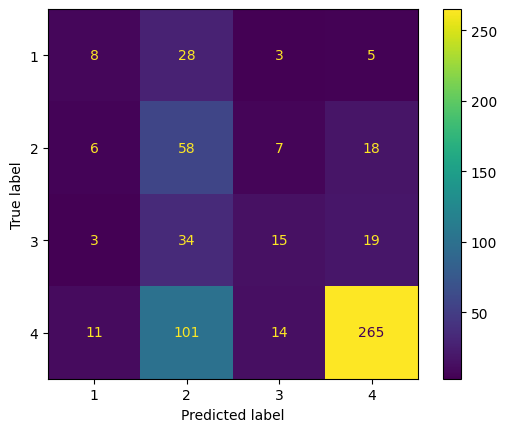

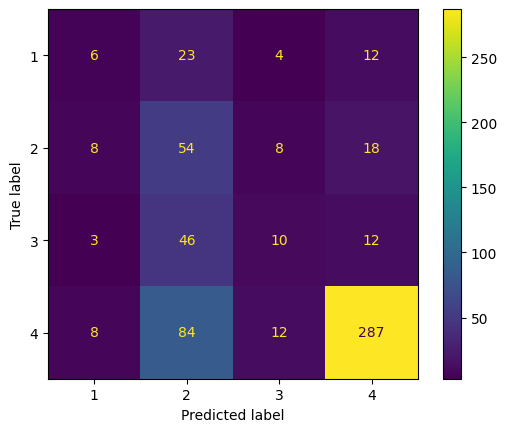

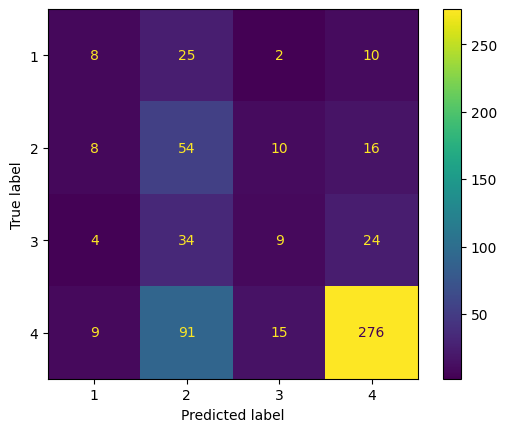

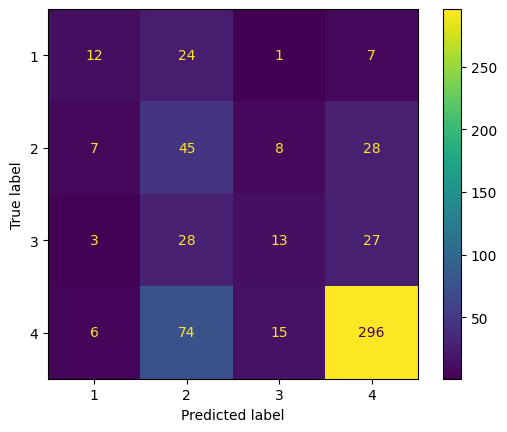

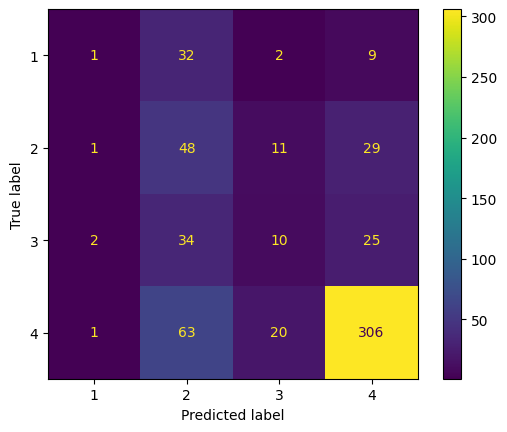

In [18]:
reg = LogisticRegression(solver='liblinear', penalty='l2')
results = loops.loop_model(reg,df,train_indices,valid_indices,oversample=ld.gen_SMOTE_data,var_thresh=True)
avg = analyze_k.average_outcome(results)
avg


In [19]:
avg_lr = analyze_k.average_outcome(lr_results)
avg_lr

{'accuracy': 0.6619619160795632,
 'f1': 0.556551415586653,
 'Macro f1': 0.2543954314948792,
 'recall_1': 0.026767676767676767,
 'precision_1': 0.7769230769230769,
 'recall_2': 0.09272216547497447,
 'precision_2': 0.32632761763196544,
 'recall_3': 0.014084507042253521,
 'precision_3': 0.14285714285714285,
 'recall_4': 0.9805587251623058,
 'precision_4': 0.6821442624804972}

# Two Stage Classification

Accuracy: 0.61
Weighted F1 Score: 0.62
Macro F1 Score: 0.43
Precision: Class 1: 0.33 Class 2: 0.25  Class 3: 0.3
           Class 4: 0.83
Recall: Class 1: 0.3 Class 2: 0.36  Class 3: 0.29
        Class 4: 0.76


Accuracy: 0.67
Weighted F1 Score: 0.61
Macro F1 Score: 0.35
Precision: Class 1: 0.75 Class 2: 0.34  Class 3: 0.28
           Class 4: 0.75
Recall: Class 1: 0.07 Class 2: 0.36  Class 3: 0.06
        Class 4: 0.93




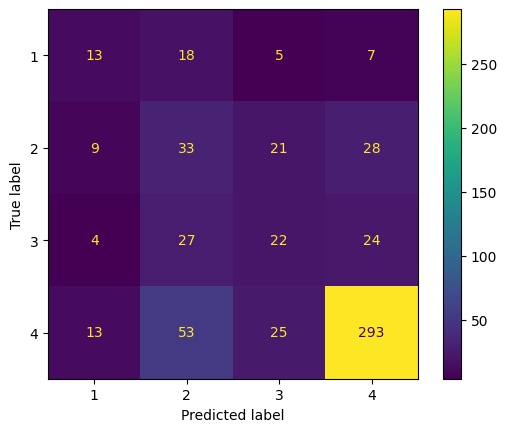

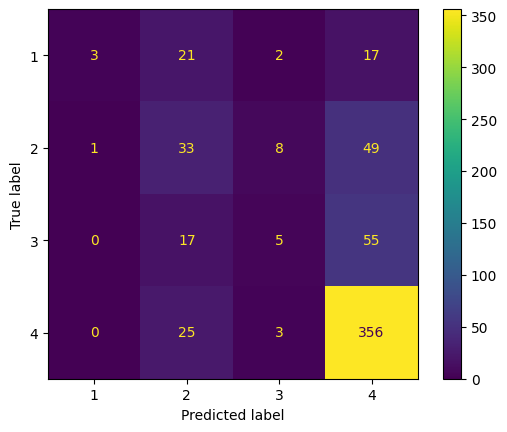

In [20]:
X = df.drop(columns="Target")
y = df.loc[:, 'Target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
train_df_resampled, train_y_resampled = ld.gen_oversample_data(train, seed = 12)
X_smote, y_smote = ld.gen_SMOTE_data(train, seed = 12)


def Two_stage(model1, model2):
    #Fit First Layer
    reg=model1.fit(X_smote, y_smote)
    y_pred = reg.predict(X_valid)
   
    #Take first layer predictions and get rid of obs we predicted
    #4 on in test set
    y_pred= pd.DataFrame(y_pred, columns=["pred"])
    a= pd.concat([X_valid.reset_index(drop=True), y_pred], axis=1)
    new_test_set= a.loc[a.loc[:,"pred"]!= 4,:]

    #Run Layer 2 on non-4 obs
    rev_dataset=pd.concat([X_smote, y_smote], axis=1)
    rev_dataset= rev_dataset.loc[rev_dataset.loc[:,"Target"]!= 4, :]
    Y= rev_dataset.loc[:,"Target"]
    X= rev_dataset.drop(columns="Target")
    reg= model2.fit(X, Y)

    #run fit on revised test set
    new_pred = reg.predict(new_test_set.drop(columns="pred"))
    #combine predictions
    a.loc[a.loc[:,"pred"]!= 4,"pred"]=new_pred
    #evaluate
    evaluate_classification(a.loc[:,"pred"], y_true = y_valid, l=[1,2,3,4], cm = True)


Two_stage(LogisticRegression(solver='liblinear', penalty='l2'),RandomForestClassifier(random_state = 12,
                        n_estimators = 1600,
                        min_samples_split = 2,
                       min_samples_leaf = 1,
                       max_features = 'sqrt',
                       max_depth = 100,
                       bootstrap = False) )
Two_stage(RandomForestClassifier(random_state = 12,
                        n_estimators = 1600,
                        min_samples_split = 2,
                       min_samples_leaf = 1,
                       max_features = 'sqrt',
                       max_depth = 100,
                       bootstrap = False),LogisticRegression(solver='liblinear', penalty='l2'))

## Binary Model

In [21]:
# Recode target classes in the DataFrame
df['Target'] = df['Target'].replace({1: 1, 2: 1, 3: 0, 4: 0})

### Naive Bayes

In [22]:
nb_results = loops.loop_model(nb, df, train_indices, valid_indices, scaler=scaler, inc_cm=False)

Accuracy: 0.75
Weighted F1 Score: 0.77
Macro F1 Score: 0.7
Precision: Experiencing Poverty: 0.47 Not Experiencing Poverty: 0.93
Recall: Experiencing Poverty: 0.8 Not Experiencing Poverty: 0.73


Accuracy: 0.72
Weighted F1 Score: 0.74
Macro F1 Score: 0.67
Precision: Experiencing Poverty: 0.43 Not Experiencing Poverty: 0.9
Recall: Experiencing Poverty: 0.72 Not Experiencing Poverty: 0.72


Accuracy: 0.73
Weighted F1 Score: 0.75
Macro F1 Score: 0.67
Precision: Experiencing Poverty: 0.43 Not Experiencing Poverty: 0.9
Recall: Experiencing Poverty: 0.71 Not Experiencing Poverty: 0.73


Accuracy: 0.73
Weighted F1 Score: 0.74
Macro F1 Score: 0.66
Precision: Experiencing Poverty: 0.43 Not Experiencing Poverty: 0.89
Recall: Experiencing Poverty: 0.67 Not Experiencing Poverty: 0.74


Accuracy: 0.72
Weighted F1 Score: 0.74
Macro F1 Score: 0.66
Precision: Experiencing Poverty: 0.42 Not Experiencing Poverty: 0.88
Recall: Experiencing Poverty: 0.65 Not Experiencing Poverty: 0.74




In [23]:
avg_nb = analyze_k.average_outcome(nb_results)
avg_nb

{'accuracy': 0.7292255892255893,
 'f1': 0.7481186203520743,
 'Macro f1': 0.6736515839684861,
 'recall_non_pov': 0.7345202880994638,
 'recall_pov': 0.710788334472545,
 'precision_non_pov': 0.8986702256191526,
 'precision_pov': 0.43446361181483895}

#### Random Forest

In [24]:
clf_results = loops.loop_model(clf, df, train_indices, valid_indices, scaler=scaler, inc_cm=False)

Accuracy: 0.81
Weighted F1 Score: 0.79
Macro F1 Score: 0.68
Precision: Experiencing Poverty: 0.64 Not Experiencing Poverty: 0.84
Recall: Experiencing Poverty: 0.37 Not Experiencing Poverty: 0.94


Accuracy: 0.79
Weighted F1 Score: 0.77
Macro F1 Score: 0.65
Precision: Experiencing Poverty: 0.57 Not Experiencing Poverty: 0.83
Recall: Experiencing Poverty: 0.33 Not Experiencing Poverty: 0.93


Accuracy: 0.79
Weighted F1 Score: 0.76
Macro F1 Score: 0.63
Precision: Experiencing Poverty: 0.54 Not Experiencing Poverty: 0.82
Recall: Experiencing Poverty: 0.3 Not Experiencing Poverty: 0.93


Accuracy: 0.82
Weighted F1 Score: 0.8
Macro F1 Score: 0.69
Precision: Experiencing Poverty: 0.71 Not Experiencing Poverty: 0.84
Recall: Experiencing Poverty: 0.36 Not Experiencing Poverty: 0.96


Accuracy: 0.82
Weighted F1 Score: 0.8
Macro F1 Score: 0.69
Precision: Experiencing Poverty: 0.65 Not Experiencing Poverty: 0.84
Recall: Experiencing Poverty: 0.4 Not Experiencing Poverty: 0.94




In [25]:
avg_clf = analyze_k.average_outcome(clf_results)
avg_clf

{'accuracy': 0.8072749908044026,
 'f1': 0.7863164280194717,
 'Macro f1': 0.6663396855750439,
 'recall_non_pov': 0.9380689447934568,
 'recall_pov': 0.35242652084757353,
 'precision_non_pov': 0.8343758100701326,
 'precision_pov': 0.6217072177856492}

#### KNN

In [26]:
knn_results = loops.loop_model(knn, df, train_indices, valid_indices, scaler=scaler, inc_cm=False)

Accuracy: 0.78
Weighted F1 Score: 0.72
Macro F1 Score: 0.54
Precision: Experiencing Poverty: 0.53 Not Experiencing Poverty: 0.79
Recall: Experiencing Poverty: 0.13 Not Experiencing Poverty: 0.97


Accuracy: 0.8
Weighted F1 Score: 0.77
Macro F1 Score: 0.62
Precision: Experiencing Poverty: 0.66 Not Experiencing Poverty: 0.82
Recall: Experiencing Poverty: 0.25 Not Experiencing Poverty: 0.96


Accuracy: 0.78
Weighted F1 Score: 0.72
Macro F1 Score: 0.53
Precision: Experiencing Poverty: 0.5 Not Experiencing Poverty: 0.79
Recall: Experiencing Poverty: 0.11 Not Experiencing Poverty: 0.97


Accuracy: 0.78
Weighted F1 Score: 0.73
Macro F1 Score: 0.56
Precision: Experiencing Poverty: 0.55 Not Experiencing Poverty: 0.8
Recall: Experiencing Poverty: 0.16 Not Experiencing Poverty: 0.96


Accuracy: 0.78
Weighted F1 Score: 0.72
Macro F1 Score: 0.54
Precision: Experiencing Poverty: 0.52 Not Experiencing Poverty: 0.79
Recall: Experiencing Poverty: 0.13 Not Experiencing Poverty: 0.97




In [27]:
avg_knn = analyze_k.average_outcome(knn_results)
avg_knn

{'accuracy': 0.7843906855671562,
 'f1': 0.7327643703066788,
 'Macro f1': 0.557425329355331,
 'recall_non_pov': 0.9653529406240903,
 'recall_pov': 0.15512645249487353,
 'precision_non_pov': 0.7990422442522206,
 'precision_pov': 0.5518066188197768}

#### Logistic Regression

Accuracy: 0.66
Weighted F1 Score: 0.69
Macro F1 Score: 0.62
Precision: Experiencing Poverty: 0.37 Not Experiencing Poverty: 0.89
Recall: Experiencing Poverty: 0.74 Not Experiencing Poverty: 0.64


Accuracy: 0.68
Weighted F1 Score: 0.7
Macro F1 Score: 0.63
Precision: Experiencing Poverty: 0.38 Not Experiencing Poverty: 0.89
Recall: Experiencing Poverty: 0.72 Not Experiencing Poverty: 0.66


Accuracy: 0.68
Weighted F1 Score: 0.7
Macro F1 Score: 0.63
Precision: Experiencing Poverty: 0.39 Not Experiencing Poverty: 0.9
Recall: Experiencing Poverty: 0.74 Not Experiencing Poverty: 0.66


Accuracy: 0.7
Weighted F1 Score: 0.73
Macro F1 Score: 0.65
Precision: Experiencing Poverty: 0.4 Not Experiencing Poverty: 0.89
Recall: Experiencing Poverty: 0.7 Not Experiencing Poverty: 0.71


Accuracy: 0.66
Weighted F1 Score: 0.68
Macro F1 Score: 0.6
Precision: Experiencing Poverty: 0.35 Not Experiencing Poverty: 0.86
Recall: Experiencing Poverty: 0.64 Not Experiencing Poverty: 0.66




{'accuracy': 0.676088051382169,
 'f1': 0.7018519202718082,
 'Macro f1': 0.6277774279475816,
 'recall_non_pov': 0.6669540148932773,
 'recall_pov': 0.7078149920255183,
 'precision_non_pov': 0.888309123983295,
 'precision_pov': 0.3795966280089983}

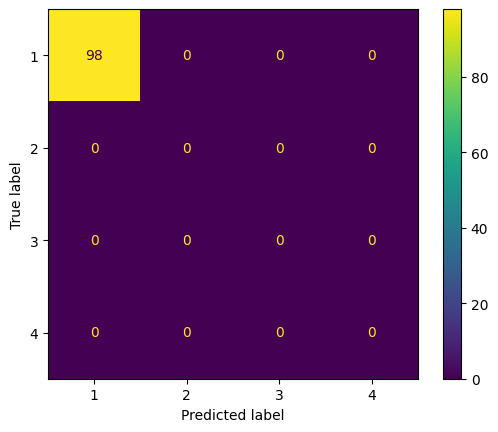

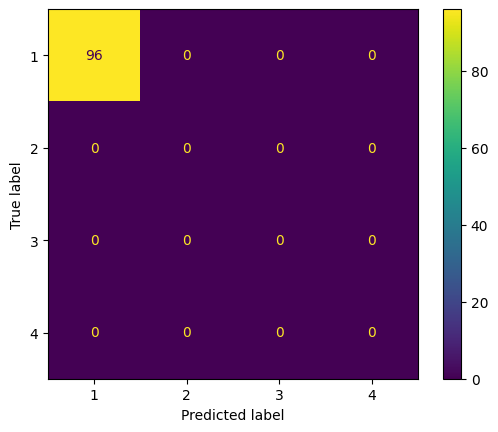

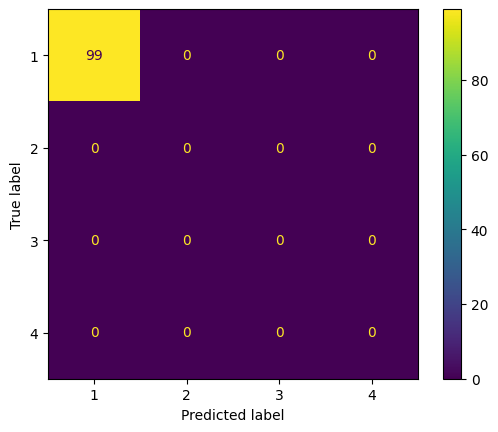

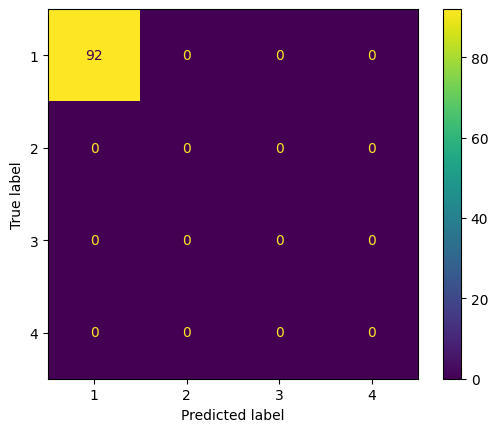

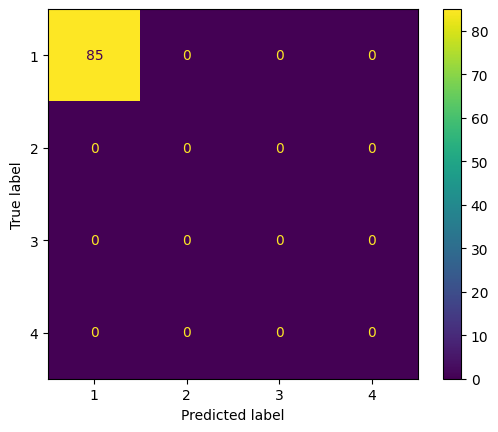

In [28]:
reg = LogisticRegression(solver='liblinear', penalty='l2')
results = loops.loop_model(reg,df,train_indices,valid_indices,oversample=ld.gen_SMOTE_data,var_thresh=True)
avg = analyze_k.average_outcome(results)
avg

# Two Stage Binary Model

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Stage 1: create a binary target separating classes 1/2 from 3/4
y_train_binary = y_train.copy()
y_train_binary[y_train_binary.isin([1, 2])] = 1
y_train_binary[y_train_binary.isin([3, 4])] = 0

# Fit the first model
model_1_2_vs_3_4 = ComplementNB()
model_1_2_vs_3_4.fit(X_train_scaled, y_train_binary)

# Make predictions and evaluate
y_pred = model_1_2_vs_3_4.predict(X_test_scaled)
evaluate_classification(y_pred, y_test)

# Stage 2: separate class 1 from class 2
mask_1_2 = y_train_binary == 1
model_1_vs_2 = ComplementNB()
model_1_vs_2.fit(X_train_scaled[mask_1_2], y_train[mask_1_2])

# Make predictions and evaluate
y_pred = model_1_vs_2.predict(X_test_scaled)
evaluate_classification(y_pred, y_test)

# Stage 3: separate class 3 from class 4
mask_3_4 = y_train_binary == 0
model_3_vs_4 = ComplementNB()
model_3_vs_4.fit(X_train_scaled[mask_3_4], y_train[mask_3_4])

# Make predictions and evaluate
y_pred = model_3_vs_4.predict(X_test_scaled)
evaluate_classification(y_pred, y_test)

NameError: name 'X_test' is not defined